In [1]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


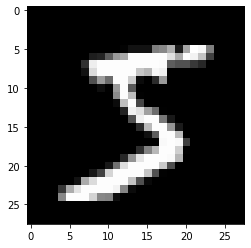

In [2]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## in thử ảnh một ảnh
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

# **1. Tạo một class DoubleFullyConnectedLayer với hàm activation lớp fully connected đầu là relu và lớp fully connected tiếp theo là softmax**

In [4]:
from keras import backend as K
from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Layer

class DoubleFullyConnectedLayer(Layer):
    def __init__(self, n_units, activation_1=tf.nn.relu, activation_2=tf.nn.softmax):
        print("__init__ called")
        ## n_units, activation là tham số do mình tự định nghĩa
        ## n_units thể hiện số nơ-ron của lớp fully connected
        ## activation là hàm kích hoạt
        
        # gọi hàm khởi tạo của lớp cha
        super(DoubleFullyConnectedLayer, self).__init__()
        # lưu lại số nơ-ron của lớp này
        self.n_units = n_units
        self.activation_function_1 = activation_1
        self.activation_function_2 = activation_2

    def build(self, input_shape):
        print("build called")
        self.kernel_1 = self.add_variable(name='kernel_1',
                                        shape=[int(input_shape[-1]), self.n_units*5],           # (*)
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
        self.kernel_2 = self.add_variable(name='kernel_2',
                                        shape=[int(self.kernel_1.shape[-1]), self.n_units], 
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
        
        ## Tương tự, khai báo một vector bias
        self.bias_1 = self.add_variable(name='bias_1',
                                      shape=[self.n_units*5],                                   # (*')
                                      initializer=keras.initializers.Ones())
        self.bias_2 = self.add_variable(name='bias_2',
                                      shape=[self.n_units],
                                      initializer=keras.initializers.Ones())


    def call(self, inputs):
        print("call called")

        ## input chính là một lớp keras (hoặc tensor) truyền vào layer này
        ## tham số input là bắt buộc
        
        ## Công thức toán học của lớp này
        ## tensorflow có hỗ broadcasting nên self.bias sẽ được cộng vào từng dòng của ma trận
        matmul_1 = tf.matmul(inputs, self.kernel_1) + self.bias_1
        outputs_1 = self.activation_function_1(matmul_1)  ##áp dụng hàm kích hoạt
        matmul_2 = tf.matmul(outputs_1, self.kernel_2) + self.bias_2
        outputs_2 = self.activation_function_2(matmul_2)  ##áp dụng hàm kích hoạt
        return outputs_2

In [5]:
class ConvMaxpoolBlock(keras.layers.Layer):
    ## Lớp này sẽ xây dựng lớp convolutional layer và maxpooling
    
    
    def __init__(self, filter_size, n_filters):
        ## filter_size sẽ dùng như là kích thước của filter của lớp convolution
        ## là một list 2 phần tử
        ## n_filters là số filter của lớp convolution
        ## là một số nguyên
        
        # gọi hàm khởi tạo của lớp cha
        super(ConvMaxpoolBlock, self).__init__()
        # lưu lại mấy thông số
        self.filter_size = filter_size
        self.n_filters = n_filters
        
    def build(self, input_shape):
        ## ta giả sử input là một tensor (layer) có kích thước [None, height, weight, n_channels]
        
        ## khởi tạo và khai báo kernel
        self.kernel = self.add_variable(name='kernel',
                                        shape=[self.filter_size[0], self.filter_size[1], int(input_shape[-1]), self.n_filters],
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        
        ## khởi tạo và khai báo bias
        self.bias = self.add_variable(name='bias',
                                      shape=[self.n_filters],
                                        initializer=keras.initializers.Ones())
        
    def call(self, inputs):
        ## phép toán tích chập
        conv = K.conv2d(x=inputs,
                            kernel=self.kernel,
                       padding='same')
        ## cộng bias (có broadcasting hỗ trợ nên lập trình đơn giản)
        conv = conv + self.bias
        ## áp dụng hàm kích hoạt
        conv = tf.nn.relu(conv)
        ## áp dụng maxpooling
        maxpool = K.pool2d(conv, 
                           pool_size=(2,2), 
                           strides=(2,2),
                          pool_mode='max')
                          
        return maxpool

# **2. Huấn luyện một neural-network theo cấu trúc đã cho**

In [6]:
## Tạo layer input, mỗi data point có kích thước (28,28)
inputs = keras.layers.Input(shape=(28,28))
print("Kích thước input: {}, None tượng trưng cho số lượng ảnh một batch không xác định trước".format(inputs.shape))

## Reshape input
inputs_reshape = keras.layers.Reshape((28,28,1))(inputs)
print("Kích thước sau reshape: {}".format(inputs_reshape.shape))

## Conv maxpool lần 1
conv_maxpool_1 = ConvMaxpoolBlock([5,5],20)(inputs_reshape)               # (1)
print("Kích thước sau conv maxpool lần 1: {}".format(conv_maxpool_1.shape))

## Conv maxpool lần 2
conv_maxpool_2 = ConvMaxpoolBlock([5,5],20)(conv_maxpool_1)               # (2)
print("Kích thước sau conv maxpool lần 1: {}".format(conv_maxpool_2.shape))

## Flatten
flatten = keras.layers.Flatten()(conv_maxpool_2)
print("Kích thước flatten: {}".format(flatten.shape))

## DoubleFullyConnected
double_fullyconnected = DoubleFullyConnectedLayer(n_units=10)(flatten)
print("Kích thước double fully connected : {}".format(double_fullyconnected.shape))

Kích thước input: (None, 28, 28), None tượng trưng cho số lượng ảnh một batch không xác định trước
Kích thước sau reshape: (None, 28, 28, 1)
Instructions for updating:
Please use `layer.add_weight` method instead.
Kích thước sau conv maxpool lần 1: (None, 14, 14, 20)
Kích thước sau conv maxpool lần 1: (None, 7, 7, 20)
Kích thước flatten: (None, 980)
__init__ called
build called
call called
Kích thước double fully connected : (None, 10)


Theo *Lab01*, ta có:


*   parameters of **conv2d**: ((shape of width of filter * shape of height filter * number of filters in the previous layer + 1) * number of filters)


*   parameters of **fully connected**: ((previous layer p * current layer c) + 1 * c)


- Giải thích $(1)$: Ta chưa biết size của filter là bao nhiêu ( width và height, đặt width = height = $n_1$), number of filters in the previous layer = 1 (previous layer is  reshape) => ( $n_1 * n_1 * 1 +1)*20 = 520 => n_1 = 5$ 

  => [shape of width of filter, shape of height filter] = [5,5]

- Giải thích $(2)$: Tương tự như trên, number of filters in the previous layer = 20 (previous layer is  conv_maxpool) => ( $n_2 * n_2 * 20 +1)*20 = 10020 => n_2 = 5$ 

  => [shape of width of filter, shape of height filter] = [5,5]


  - Giải thích $(*)$ và $(*')$: Dựa vào công thức tính số lượng parameters của lớp fully connected, ta có: 
      + Lớp fully connected thứ 1, số lượng parameters = $(980 * c) + 1 * c$
      + Lớp fully connected thứ 2, số lượng parameters = $(c * 10) + 1 * 10$

      Theo đề bài, số lượng parameters này bằng 49560

      => $(980 * c) + 1 * c + (c * 10) + 1 * 10 = 49560$

      => $c = 50$

      Do đó, n_units ở lớp fully connected thứ 2 = 10 thì **n_units** ở lớp fully connected thứ 1 = **50** và n_units ở bias cũng phải bằng n_units ở kernel

    






In [7]:
## Tạo model, với input là lớp inputs, outputs là lớp double fully connected
model = keras.models.Model(inputs=inputs, outputs=double_fullyconnected)

## Compile model
  
model.compile(optimizer='adam',
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

## In toàn bộ cấu trúc của model
print("Cấu trúc của model: ")
model.summary()

Cấu trúc của model: 
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_maxpool_block (ConvMaxp (None, 14, 14, 20)        520       
_________________________________________________________________
conv_maxpool_block_1 (ConvMa (None, 7, 7, 20)          10020     
_________________________________________________________________
flatten (Flatten)            (None, 980)               0         
_________________________________________________________________
double_fully_connected_layer (None, 10)                49560     
Total params: 60,100
Trainable params: 60,100
Non-trainable params: 0
_____________________________

**Training**

In [9]:
history=model.fit(X_train,y_train,
                  epochs=10,
                  batch_size=256,
                  validation_data=(X_valid,y_valid))

## Lưu model thành một file
model.save_weights("first_model.h5")


## Load model
model.load_weights("first_model.h5")

## Đánh giá model trên tập test
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Loss trên tập test: ", test_loss," Accuracy trên tập test: ", test_acc)

Epoch 1/10
211/211 [==============================] - 60s 285ms/step - loss: 0.2699 - accuracy: 0.9171 - val_loss: 0.1905 - val_accuracy: 0.9413
Epoch 2/10
211/211 [==============================] - 61s 288ms/step - loss: 0.1473 - accuracy: 0.9553 - val_loss: 0.1199 - val_accuracy: 0.9653
Epoch 3/10
211/211 [==============================] - 60s 286ms/step - loss: 0.1007 - accuracy: 0.9693 - val_loss: 0.0935 - val_accuracy: 0.9703
Epoch 4/10
211/211 [==============================] - 64s 304ms/step - loss: 0.0805 - accuracy: 0.9747 - val_loss: 0.0881 - val_accuracy: 0.9720
Epoch 5/10
211/211 [==============================] - 60s 286ms/step - loss: 0.0662 - accuracy: 0.9796 - val_loss: 0.0814 - val_accuracy: 0.9763
Epoch 6/10
211/211 [==============================] - 60s 286ms/step - loss: 0.0579 - accuracy: 0.9817 - val_loss: 0.0609 - val_accuracy: 0.9807
Epoch 7/10
211/211 [==============================] - 61s 288ms/step - loss: 0.0524 - accuracy: 0.9834 - val_loss: 0.0642 - val_ac

# **3. Vẽ biểu đồ accuracy từng epoch trên tập training và tập validation**

In [32]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


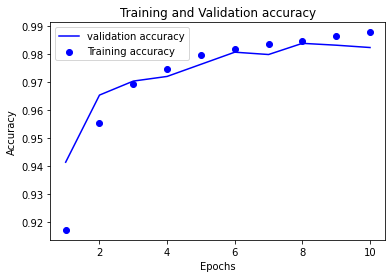

In [33]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,11) #có 10 epochs
plt.scatter(epochs, acc_train, c = 'b', label='Training accuracy')
plt.plot(epochs, acc_val, c = 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()